In [4]:
%matplotlib inline

# useful packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx
import time
import pandas as pd

from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit.quantum_info import Statevector
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere
import qiskit

In [5]:
# graph generation

def draw_graph(G, colors, pos):
        default_axes = plt.axes(frameon=True)
        nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
        edge_labels = nx.get_edge_attributes(G, "weight")
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

def graph_generation(dim):
    # Generating the system
    N = dim
    G1 = nx.grid_2d_graph(N,N)
    pos = dict( (n, n) for n in G1.nodes() )
    labels = dict( ((i, j), i * N + j) for i, j in G1.nodes() )
    # Transform to weighted graph:
    n = N**2
    V = np.arange(0, N, 1)

    E =[]

    tuples = []
    other_tup = []
    point_edge_map = []
    other_map = []
    relations = []

    for edge in G1.edges:
        point1 = edge[0]
        strpoint1 = str(point1[0]) + str(point1[1])
        point2 = edge[1]
        strpoint2 = str(point2[0]) + str(point2[1])
        if not strpoint1 in point_edge_map:
            point_edge_map.append(strpoint1)
            tuples.append(edge[0])
        if not strpoint2 in other_map:
            other_map.append(strpoint2)
            other_tup.append(edge[1])
        relations.append((strpoint1, strpoint2))

    # add periodic boundary conditions
    grid = np.zeros((dim, dim)).astype('int64').tolist()
    for i in range(dim):
        for j in range(dim):
            pt = str(i) + str(j)
            grid[i][j] = pt
    for i in range(len(grid)):
        relations.append((grid[0][i], grid[dim-1][i]))
        relations.append((grid[i][0], grid[i][dim-1]))        
    
    
    tuples.append(other_tup[len(other_tup) - 1])
    point_edge_map.append(other_map[len(other_map) - 1])

    dic = {}
    for i in range(len(point_edge_map)):
        dic[i] = point_edge_map[i]

    point_edge_map = np.array(point_edge_map)
    relations = np.array(relations)

    for relation in relations:
        ver1 = relation[0]
        ver2 = relation[1]
        point1 = np.where(point_edge_map == ver1)[0][0]
        point2 = np.where(point_edge_map == ver2)[0][0]
        edge = (point1, point2, 1.0)
        E.append(edge)

    G = nx.Graph()

    G.add_nodes_from(V)

    G.add_weighted_edges_from(E)

    colors = ["b" for node in G.nodes()]
    pos = dict()
    for i in range(n):
        pos[i] = tuples[i]


    draw_graph(G, colors, pos)
    
    # Matrix Representation of Graph
    w = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            temp = G.get_edge_data(i, j, default=0)
            if temp != 0:
                w[i, j] = temp["weight"]
                
    return G, w, pos

In [6]:
# output probability
def output_prob(parameters, size, rep): 
    '''
    parameters from vqe, size should be (number of interations, size**2 * rep)
    size: size of the ising model 
    rep: number of rep in the ansatz
    '''
    ### assign parameter in the circuit 
    num_q = size**2
    qc = QuantumCircuit(num_q)
    for i in range(rep+1):
        for j in range(num_q): 
            qc.ry(parameters[j+i*num_q], j)
    
    ### measure 
    final_counts = backend.run(qc, shot=5000).result().get_counts(qc)
    print(final_counts)
    probs = Statevector(final_counts).probabilities()
    # coeff is the square root of probs 
    coeff = np.sqrt(probs)
    
    # function for writing wave function in binary form
    def zero(a,num_q):
        string = ''
        if len(a) < num_q:
            for _ in range(num_q-len(a)):
                string += '0'
            string += a
            return string
        # add an else statement
        else:
            return a

    info = {}
    # the largest integer that format() can convert to binary is 255.
    for i in range(len(coeff)):
        info[zero(bin(i)[2:], num_q)] = np.round(coeff[i], 3)
    return info

CPU times: user 12h 50min 6s, sys: 20h 24min 21s, total: 1d 9h 14min 28s
Wall time: 6h 57min 6s


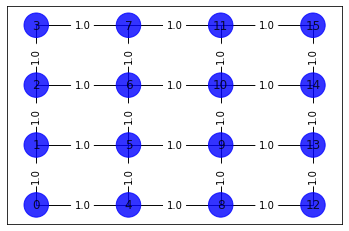

In [7]:
%%time
backend = Aer.get_backend('qasm_simulator')
# seed = 250
# algorithm_globals.random_seed = seed
# quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

iterations = np.linspace(2000, 2000, 1, dtype = 'int64')
seeds = np.linspace(201, 1000, 800, dtype = 'int64')

writer = pd.ExcelWriter('4x4 periodic.xlsx', engine = 'xlsxwriter')
for maxiter in iterations:
    G, w, pos = graph_generation(4)
    max_cut = Maxcut(w)
    qp = max_cut.to_quadratic_program()
    qubitOp, offset = qp.to_ising()
    exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())

    data = pd.DataFrame()
    size = np.full_like(seeds, 16)
    optimizER = "COBYLA(maxiter=" + str(maxiter) + ")"
    opt = []
    first_state = []
    first_prob = []
    first_energy = []
    terminate_it = []
    energy = []
    time = []
    max_cum_objective = []
    solution = []
    solution_objective = []
    
    for i, seed in enumerate(seeds):
        algorithm_globals.random_seed = seed
        quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
        

        # construct VQE
        cobyla = COBYLA(maxiter = maxiter)
        ry = TwoLocal(qubitOp.num_qubits, "ry", reps=1, entanglement="linear")
        # monitoring VQE
        counts, values, Parameters = [], [], []
        def store_intermediate_result(eval_count, parameter, mean, std):
            counts.append(eval_count)
            values.append(mean)
            Parameters.append(parameter)
        
        vqe = VQE(ry, optimizer=cobyla, callback=store_intermediate_result, quantum_instance=quantum_instance)
        
        # run VQE
        result = vqe.compute_minimum_eigenvalue(qubitOp)
        x = max_cut.sample_most_likely(result.eigenstate)
        
        # state after the first iteration
        # print(Parameters[0], 4, 1)
        # first_it = output_prob(Parameters[0], 4, 1)
        # f_prob, f_state = max(first_it.values()), max(first_it, key = first_it.get)
        
        # data collection
        # first_state.append(f_state)
        # first_prob.append(f_prob)
        # first_energy.append(values[0])
        terminate_it.append(len(Parameters))
        opt.append(optimizER)
        energy.append(result.eigenvalue.real)
        time.append(result.optimizer_time)
        max_cum_objective.append(result.eigenvalue.real + offset)
        solution.append(max_cut.sample_most_likely(result.eigenstate))
        solution_objective.append(qp.objective.evaluate(x))

    # data base
    data['seed'] = seeds
    data['size'] = size
    data['optimizer'] = opt
    # data['state after 1st iteration'] = first_state
    # data['probability for the 1st state'] = first_prob
    # data['energy for the 1st state'] = first_energy
    data['terminate iterations'] = terminate_it
    data['energy'] = energy
    data['time (s)'] = time
    data['max cut objective'] = max_cum_objective
    data['solution'] = solution
    data['solution objective'] = solution_objective
    data.to_excel(writer, sheet_name = "maxiter=" + str(maxiter))
    
writer.save()